# This notebook contains simple experiments, which is for joy!

In [1]:
import numpy as np
import matplotlib.pylab as plt
import os
import csv
import pickle
import tensorflow as tf
import tensorflow.contrib.slim as slim

# 1.Construct the graph of normal Feed-forward Neural Network (MLP)

In [2]:
def MLP(_x, hidden_units = [32, 32], output_dim = 2, keep_probs = 0.6, reuse = False):
    batch_norm_params = {'is_training': is_training, 'decay': 0.9
                         , 'updates_collections': None}
    fc1 = slim.fully_connected(_x, hidden_units[0], 
                               activation_fn = tf.nn.relu,
                               weights_initializer = initializer,
                               normalizer_fn = slim.batch_norm,
                               normalizer_params = batch_norm_params,
                               scope = 'fc1',
                               reuse = reuse
                              )
    fc2 = slim.fully_connected(fc1, hidden_units[1],
                               activation_fn = tf.nn.relu,
                               weights_initializer = initializer,
                               normalizer_fn = slim.batch_norm,
                               normalizer_params = batch_norm_params,
                               scope = 'fc2',
                               reuse = reuse
                              )
    dropout2 = slim.dropout(fc2, keep_prob = keep_probs, is_training = is_training, scope = 'dropout2')
    fc3 = slim.fully_connected(dropout2, output_dim,
                               activation_fn = None,
                               scope = 'fc3',
                               reuse = reuse
                              )
    return fc3

# 2.Load MNIST database & data preprocessing

Extracting ./MNIST/train-images-idx3-ubyte.gz
Extracting ./MNIST/train-labels-idx1-ubyte.gz
Extracting ./MNIST/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/t10k-labels-idx1-ubyte.gz
The number of training samples is 12873, including sample 1: 6742, sample 3: 6131
The number of testing samples is 2145, including digit 1: 1135, digit 3: 1010


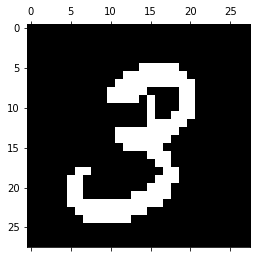

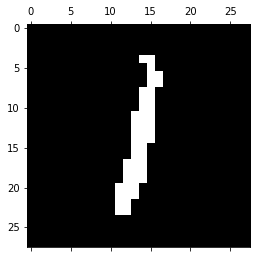

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data_dir = './MNIST'
mnist_input = input_data.read_data_sets(data_dir, one_hot = True)
#select two classes:digit '1' and '3'
dataset_images = np.vstack((mnist_input.train.images, mnist_input.validation.images, mnist_input.test.images))
dataset_labels = np.vstack((mnist_input.train.labels, mnist_input.validation.labels, mnist_input.test.labels))
is_digit_1, is_digit_3 = (dataset_labels[:, 1] == 1.), (dataset_labels[:, 3] == 1.)
selected_training = is_digit_1[:60000] + is_digit_3[:60000]
selected_test = is_digit_1[60000:] + is_digit_3[60000:]
selected = is_digit_1 + is_digit_3

#discretize the attributes, and round the pixel to be 0 or 1
training_x = np.round(dataset_images[:60000][selected_training], 0)
training_y = dataset_labels[:60000][selected_training][:, [1, 3]]
#discretize the attributes, and round the pixel to be 0 or 1
test_x = np.round(dataset_images[60000:][selected_test], 0)
test_y = dataset_labels[60000:][selected_test][:, [1, 3]]

#output some useful imformation
MSG = 'The number of training samples is {0}, including sample 1: {1}, sample 3: {2}' 
print MSG.format(training_x.shape[0], np.sum(is_digit_1[:60000]), np.sum(is_digit_3[:60000]))
MSG = 'The number of testing samples is {0}, including digit 1: {1}, digit 3: {2}' 
print MSG.format(test_x.shape[0], np.sum(is_digit_1[60000:]), np.sum(is_digit_3[60000:]))

for i in range(2):
    plt.matshow(training_x[i, :].reshape(28, 28), vmin = 0., vmax = 1., cmap = plt.cm.gray)
    plt.show()

# 3. Set hyper-parameters of MLP & Creat optimizer

In [4]:
import utils
#save dir
model_dir = './models/'
    
params = {
    'n_epoches':20,
    'batchsize':128,
    'learning_rate':0.001
}
args = utils.ParamWrapper(params)
input_dims = training_x.shape[1]
output_dims = 2

tf.reset_default_graph()
tf.set_random_seed(1234)
#complate the DNN graph
x = tf.placeholder(dtype = tf.float32, shape = [None, input_dims], name = 'X')
y = tf.placeholder(dtype = tf.float32, shape = [None, output_dims], name = 'Y')
is_training = tf.placeholder(tf.bool)
#inference 
initializer = tf.random_normal_initializer(0, 0.01)
mlp = MLP(x, output_dim= output_dims, hidden_units=[32, 32])
mlp_softmax = tf.nn.softmax(mlp)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels= y, logits= mlp))
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(mlp, axis = 1), tf.argmax(y, axis = 1)), tf.float32))
#select Adam optimizer
optimizer = tf.train.AdamOptimizer(args.learning_rate).minimize(loss) 

# 4. Optimize the parameters of MLP

In [5]:
sess = tf.Session()
init = tf.global_variables_initializer()
with sess.as_default():
    sess.run(init)
    best_acc = 0.
    n_batches = training_x.shape[0] // args.batchsize + 1
    iterations = 0.
    display = 100
    for epoch in range(args.n_epoches):
        for mini_index in range(n_batches):
            start_i = mini_index * args.batchsize
            end_i = start_i + args.batchsize
            if end_i > training_x.shape[0]:
                end_i = training_x.shape[0]
            if end_i == start_i:
                break
            _feed_dicts = {
                x: training_x[start_i: end_i],
                y: training_y[start_i: end_i],
                is_training: True
            }
            _, _loss = sess.run([optimizer, loss], feed_dict = _feed_dicts)
            iterations = mini_index + 1 + epoch * n_batches
            if iterations % display == 0:
                _feed_dicts = {
                    x: test_x,
                    y: test_y,
                    is_training: False
                }
                _acc = sess.run(acc, feed_dict = _feed_dicts)
                if _acc > best_acc:
                    best_acc = _acc
                MSG = "iterations:{0}, training loss: {1:.3}, validation accuracy:{2:.3}, best accuracy:{3:.3}"
                print MSG.format(iterations, _loss, _acc, best_acc)


iterations:100, training loss: 0.0411, validation accuracy:0.997, best accuracy:0.997
iterations:200, training loss: 0.00755, validation accuracy:0.996, best accuracy:0.997
iterations:300, training loss: 0.00424, validation accuracy:0.999, best accuracy:0.999
iterations:400, training loss: 0.00951, validation accuracy:0.999, best accuracy:0.999
iterations:500, training loss: 0.00153, validation accuracy:0.999, best accuracy:0.999
iterations:600, training loss: 0.00109, validation accuracy:1.0, best accuracy:1.0
iterations:700, training loss: 0.000604, validation accuracy:0.999, best accuracy:1.0
iterations:800, training loss: 0.000528, validation accuracy:0.999, best accuracy:1.0
iterations:900, training loss: 0.000569, validation accuracy:0.999, best accuracy:1.0
iterations:1000, training loss: 0.000526, validation accuracy:0.999, best accuracy:1.0
iterations:1100, training loss: 0.000198, validation accuracy:0.999, best accuracy:1.0
iterations:1200, training loss: 0.000212, validatio

# ================Generating Adversarial Examples================

In [6]:
#evaluate samples at scale
def evaluate_model(sess, dataX, labely):
    eval_batches = dataX.shape[0] // args.batchsize + 1
    accs = []
    mlp_out = []
    with sess.as_default():
        for mini_index in range(eval_batches):
            start_i = mini_index * args.batchsize
            end_i = start_i + args.batchsize
            if end_i > dataX.shape[0]:
                end_i = dataX.shape[0]
            if start_i == end_i:
                break
            _feed_dicts = {
                x: dataX[start_i: end_i],
                y: labely[start_i: end_i],
                is_training: False
            }
            _acc, _out = sess.run([acc, mlp_softmax], feed_dict = _feed_dicts)
            accs.append(_acc)
            mlp_out.append(_out)
        return np.mean(np.array(accs)), np.vstack(mlp_out)
#evaluate small amounts of samples    
def evaluate_samples_s(sess, samples, labels):
    with sess.as_default():
        _feed_dict = {
            x:samples,
            y:labels,
            is_training:False
        }
        return sess.run(acc, feed_dict = _feed_dict)

Select 200 instances classified correctly by the MLP from test dataset. 
We only consider that '1' is perturbed into '3', which imtates the constraints of malware applications

In [7]:
#select 1
test_digit1_idx = test_y[:, 0] == 1 
test_digit1_x = test_x[test_digit1_idx]
test_digit1_y = test_y[test_digit1_idx]
#evluation
test_acc, test_out = evaluate_model(sess, test_digit1_x, test_digit1_y)
#select examples
correct_idx = np.equal(np.argmax(test_out, axis = 1), np.argmax(test_digit1_y, axis = 1))
pre_attack_samples = test_digit1_x[correct_idx][:200]
pre_attack_sam_labels = test_digit1_y[correct_idx][:200] #[1, 0]

# 5.Fast gradient sign method (FGS)

In [9]:
#Fast gradient sign method
#'Explaining and Harnessing Adversarial Examples': 'https://arxiv.org/abs/1412.6572'
#graph
def fgsm_graph(x, preds):
    preds_max = tf.reduce_max(preds, axis = 1, keep_dims = True)
    preds_y = tf.to_float(tf.equal(preds_max, preds))
    preds_y = tf.stop_gradient(preds_y)
    preds_y = preds_y / tf.reduce_sum(preds_y, 1, keep_dims= True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels= preds_y, logits= preds))
    grad, = tf.gradients(loss, x)
    return tf.sign(grad), grad
#run
def fgsm(sess, X, label, invalid_positions, top_k = 20, metrics = "L0"):
    grads_sign, grads = fgsm_graph(x, mlp)
    with sess.as_default():
        _feed_dict = {
            x:X,
            y:label,
            is_training: False
        }
        _grads_sign, _grads = sess.run([grads_sign, grads], feed_dict = _feed_dict)
    _grads[invalid_positions] = np.min(_grads)
    #randomly chose elements whose gradiends is positive
    _grads = np.clip(_grads, a_min= 0.0, a_max= 12456.) 
    top_k_batch = np.argpartition(_grads, np.argmin(_grads, axis = 0))[:, -top_k:]
    adv_X = np.copy(X)
    for i, mal in enumerate(adv_X):
        mal[top_k_batch[i]] = 1.
    return np.clip(adv_X, a_min = 0, a_max = 1.)

In [10]:
perturbations = [10, 20, 50, 100]
#call fgsm function
def get_adv_examples(mal_x, mal_y, perturbs):
    adv_smp_fgsm = []
    adv_batches = mal_x.shape[0] // args.batchsize + 1
    with sess.as_default():
        for mini_b in range(adv_batches):
            start_i = mini_b * args.batchsize
            end_i = start_i + args.batchsize
            if end_i > mal_x.shape[0]:
                end_i = mal_x.shape[0]
            mal_data = mal_x[start_i : end_i]
            mal_label = mal_y[start_i : end_i]
            invalid_pos = (mal_data == 1.)
            adv_smp_fgsm.append(fgsm(sess, mal_data, mal_label, invalid_pos, top_k= perturbs))
    return np.array(np.vstack(adv_smp_fgsm))


In [11]:
#get adversarial exampels
modified_smps_fgsm_10 = get_adv_examples(pre_attack_samples, pre_attack_sam_labels, perturbations[0])
modified_smps_fgsm_20 = get_adv_examples(pre_attack_samples, pre_attack_sam_labels, perturbations[1])
modified_smps_fgsm_50 = get_adv_examples(pre_attack_samples, pre_attack_sam_labels, perturbations[2])
modified_smps_fgsm_100 = get_adv_examples(pre_attack_samples, pre_attack_sam_labels, perturbations[3])

In [12]:
#evluate classification over clean samples and corresponding adversarial examples
acc_clean = evaluate_samples_s(sess, pre_attack_samples, pre_attack_sam_labels)
acc_fgs10 = evaluate_samples_s(sess, modified_smps_fgsm_10, pre_attack_sam_labels)
acc_fgs20 = evaluate_samples_s(sess, modified_smps_fgsm_20, pre_attack_sam_labels)
acc_fgs50 = evaluate_samples_s(sess, modified_smps_fgsm_50, pre_attack_sam_labels)
acc_fgs100 =  evaluate_samples_s(sess, modified_smps_fgsm_100, pre_attack_sam_labels)
MSG = "The classification accuracy over clean data: {0:.5} vs adverarial samples (bound 10, 20, 50, 100): {1:.5}, {2:.5}, {3:.5}, {4:.5}"
print(MSG.format(acc_clean, acc_fgs10, acc_fgs20, acc_fgs50, acc_fgs100))

The classification accuracy over clean data: 1.0 vs adverarial samples (bound 10, 20, 50, 100): 0.95, 0.47, 0.01, 0.0


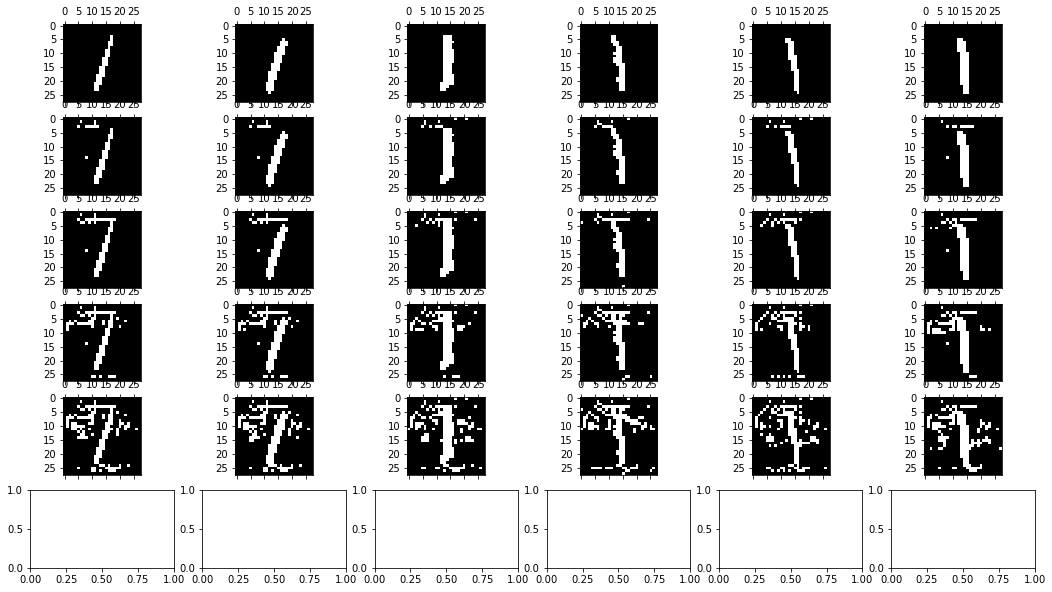

In [13]:
#display the clean examples and adversarial examples
n_examples = 6
fig, axs = plt.subplots(6, n_examples, figsize = (18, 10))

for i in range(n_examples):
    #clean
    axs[0][i].matshow(np.reshape(pre_attack_samples[i], (28, 28)), vmin = 0, vmax = 1., cmap = plt.cm.gray)
    #scale of perturbation is 10
    axs[1][i].matshow(np.reshape(modified_smps_fgsm_10[i], (28, 28)), vmin = 0, vmax = 1., cmap = plt.cm.gray)
    #scale of perturbation is 20
    axs[2][i].matshow(np.reshape(modified_smps_fgsm_20[i], (28, 28)), vmin = 0, vmax = 1., cmap = plt.cm.gray)
    #scale of perturbation is 50
    axs[3][i].matshow(np.reshape(modified_smps_fgsm_50[i], (28, 28)), vmin = 0, vmax = 1., cmap = plt.cm.gray)
    #scale of perturbation is 100
    axs[4][i].matshow(np.reshape(modified_smps_fgsm_100[i], (28, 28)), vmin = 0, vmax = 1., cmap = plt.cm.gray)
plt.show()

the distortion data is saved to [./MNIST/clean.data]
the distortion data is saved to [./MNIST/clean.label]
the distortion data is saved to [./MNIST/fgsm_10.data]
the distortion data is saved to [./MNIST/fgsm_20.data]
the distortion data is saved to [./MNIST/fgsm_50.data]
the distortion data is saved to [./MNIST/fgsm_100.data]
====================the save data=================


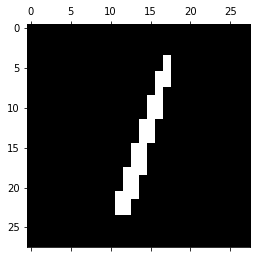

In [14]:
#save samples to current directory
save_dir = "./MNIST"
save_path1 = os.path.join(save_dir, 'clean.data')
save_path2 = os.path.join(save_dir, 'fgsm_10.data')
save_path3 = os.path.join(save_dir, 'fgsm_20.data')
save_path4 = os.path.join(save_dir, 'fgsm_50.data')
save_path5 = os.path.join(save_dir, 'fgsm_100.data')
save_path_label = os.path.join(save_dir, 'clean.label')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
with open(save_path1, 'wb') as fsave:
    np.save(fsave, pre_attack_samples)
    print("the distortion data is saved to [%s]" % save_path1)
    
with open(save_path_label, 'wb') as fsave:
    np.save(fsave, pre_attack_sam_labels)
    print("the distortion data is saved to [%s]" % save_path_label)
    
with open(save_path2, 'wb') as fsave:
    np.save(fsave, modified_smps_fgsm_10)
    print("the distortion data is saved to [%s]" % save_path2)
    
with open(save_path3, 'wb') as fsave:
    np.save(fsave, modified_smps_fgsm_20)
    print("the distortion data is saved to [%s]" % save_path3)
    
with open(save_path4, 'wb') as fsave:
    np.save(fsave, modified_smps_fgsm_50)
    print("the distortion data is saved to [%s]" % save_path4)
    
with open(save_path5, 'wb') as fsave:
    np.save(fsave, modified_smps_fgsm_100)
    print("the distortion data is saved to [%s]" % save_path5)

#cheak the saved data
with open(save_path1, 'rb') as fload:
    samples = utils.readdata_np(save_path1)
    print("====================the save data=================")
    plt.matshow(samples[0, :].reshape(28, 28), vmin = 0., vmax = 1., cmap = plt.cm.gray)
    plt.show()

# 2.Optimization Approach

In [15]:
#inference: x' = x + dist * valid
batch_size = 1 #only support single samples
#the elements can be perturbed
valid_M = tf.placeholder(dtype = tf.float32, shape = [None, input_dims], name = "VALID_M")
delta_M = tf.Variable(tf.zeros([batch_size, input_dims]))
modified_malware = x + delta_M * valid_M
modified_mlp_out = MLP(modified_malware, output_dim= output_dims, hidden_units=[32, 32], reuse = True) #use pre-trained parameters of vallina networks

#loss1 = tf.log(tf.constant(2.))-tf.nn.softplus(tf.reduce_sum(dist_mlp_out * y, axis = 1) - tf.reduce_max(dist_mlp_out * (1. - y), axis = 1))
#loss1 = -tf.maximum(tf.reduce_sum(dist_mlp_out * y, axis = 1) - tf.reduce_max(dist_mlp_out * (1. - y), axis = 1), 0.0)
#loss1 = -tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= dist_mlp_out, labels= 1. -y))
loss1 = tf.log(1. - tf.reduce_mean(tf.nn.softmax(modified_mlp_out) * y ,axis = 1) + 1e-6)
loss2 = tf.reduce_sum(tf.square(delta_M * valid_M))
loss = loss1 + loss2
optimizer_perturbe = tf.train.AdamOptimizer()
trainer = optimizer_perturbe.minimize(loss, var_list = [delta_M])
guide_grad = tf.gradients(loss1, modified_malware)

In [16]:
is_vars_inited_graph = [tf.is_variable_initialized(var) for var in tf.global_variables()]
#tf.set_random_seed(1234)
def logist_zero_sum_approach(sess, malware, label, valid, maxIters = 1000, select_num = 2):    
    with sess.as_default():
        is_inited = sess.run(is_vars_inited_graph)
        uninited_vars = [var for (var, init) in 
                         zip(tf.global_variables(), is_inited) if not init]
        if len(uninited_vars):
            sess.run(tf.variables_initializer(uninited_vars))

        _feed_dict = {
                x: malware,
                y: label,
                valid_M: valid,
                is_training:False
            }
        display_ = int(maxIters * 0.1)
        argminset = set()
        for idx in range(maxIters):
            _, _loss_dist, _grads, _modified_malware= \
            sess.run([trainer, loss,  guide_grad, modified_malware], feed_dict = _feed_dict)
            if idx % display_ == 0:
                #check
                grads_valid = _grads * valid
                grads_flatten = np.reshape(grads_valid, -1)
                pre_invalid_count = int(np.sum(valid) * 0.1)
                argmin_sort = np.argsort(grads_flatten)
                argmin = []
                for _i, _e in enumerate(argmin_sort[:-select_num]):
                    if _e not in argminset:
                        argminset.add(_e)
                        argmin.append(_e)
                    if len(argmin) >= pre_invalid_count:
                        break
                argmax = np.argsort(grads_flatten)[-select_num:]
                valid[:, argmin] = 0.
                if np.min(_modified_malware[:, argmax]) > 1:
                    break
                _feed_dict = {x:malware, y:label, valid_M: valid, is_training: False}
            
    return argmax, _grads, valid, _modified_malware

In [17]:
perturbations2 = [5, 10, 20]
def get_adv_examples_opt(mal_x, mal_y, perturbs):
    modified_smps_op = []
    select_num = 1 #change the top-1 gradients
    for _i, _attack_sample in enumerate(mal_x):
        print("start modifying attack samples %d" % _i)
        attack_smp = _attack_sample.copy()
        attack_smp = np.reshape(attack_smp, (1, attack_smp.shape[0]))
        label_ = np.array([[1, 0]], dtype = np.float32)
        valid = 1. - attack_smp
        valid_count_sum = np.sum(valid)
        #perturbation
        for dist_i in range(perturbs):
            _feed_dict = {
                x:attack_smp,
                is_training:False,
                valid_M: valid
            }
            print ("the output of DNN:",sess.run(mlp, feed_dict = _feed_dict))
            _argmax, _grads_status, update_valid,_ = \
            logist_zero_sum_approach(sess, attack_smp, label_, valid, select_num= select_num)

            print("The valid features count is %d/%d" % (np.sum(update_valid), valid_count_sum))
            if np.sum(update_valid) == 0:
                print("Warning: No valid features to perbutate")
            attack_smp[:, _argmax] = 1.
            '''
            _acc2 = evaluate_samples_s(sess, attack_smp, label_)
            if _acc2 == 0.:
                print "attacking Successfully!"
            '''
            valid = 1. - attack_smp
        modified_smps_op.append(attack_smp)
        #perturbations.append(select_num * (dist_i+ 1))
    return np.squeeze(np.vstack(modified_smps_op))

In [18]:
modified_smps_opt_5 = get_adv_examples_opt(pre_attack_samples, pre_attack_sam_labels, perturbations2[0])
modified_smps_opt_10 = get_adv_examples_opt(pre_attack_samples, pre_attack_sam_labels, perturbations2[1])
modified_smps_opt_20 = get_adv_examples_opt(pre_attack_samples, pre_attack_sam_labels, perturbations2[2])

start modifying attack samples 0
('the output of DNN:', array([[ 6.22662544, -6.69644833]], dtype=float32))
The valid features count is 289/745
('the output of DNN:', array([[ 5.2072072 , -5.60350132]], dtype=float32))
The valid features count is 290/745
('the output of DNN:', array([[ 4.22237301, -4.56019497]], dtype=float32))
The valid features count is 291/745
('the output of DNN:', array([[ 3.01686668, -3.44232774]], dtype=float32))
The valid features count is 290/745
('the output of DNN:', array([[ 1.41527212, -2.04542851]], dtype=float32))
The valid features count is 291/745
start modifying attack samples 1
('the output of DNN:', array([[ 6.50709152, -6.99444628]], dtype=float32))
The valid features count is 297/728
('the output of DNN:', array([[ 5.51880455, -5.93201494]], dtype=float32))
The valid features count is 297/728
('the output of DNN:', array([[ 4.62679625, -4.9824276 ]], dtype=float32))
The valid features count is 299/728
('the output of DNN:', array([[ 3.83816504, -4

In [19]:
#evaluate the classification accuracy over adversarial exampels
acc_opt5 = evaluate_samples_s(sess, modified_smps_opt_5, pre_attack_sam_labels)
acc_opt10 = evaluate_samples_s(sess, modified_smps_opt_10, pre_attack_sam_labels)
acc_fgs20 = evaluate_samples_s(sess, modified_smps_opt_20, pre_attack_sam_labels)
MSG = "The classification accuracy over clean data: {0:.5} vs adverarial samples (bound 5, 10, 20): {1:.5}, {2:.5}, {3:.5}"
print(MSG.format(acc_clean, acc_opt5, acc_opt10, acc_fgs20))

The classification accuracy over clean data: 1.0 vs adverarial samples (bound 5, 10, 20): 0.38, 0.0, 0.0


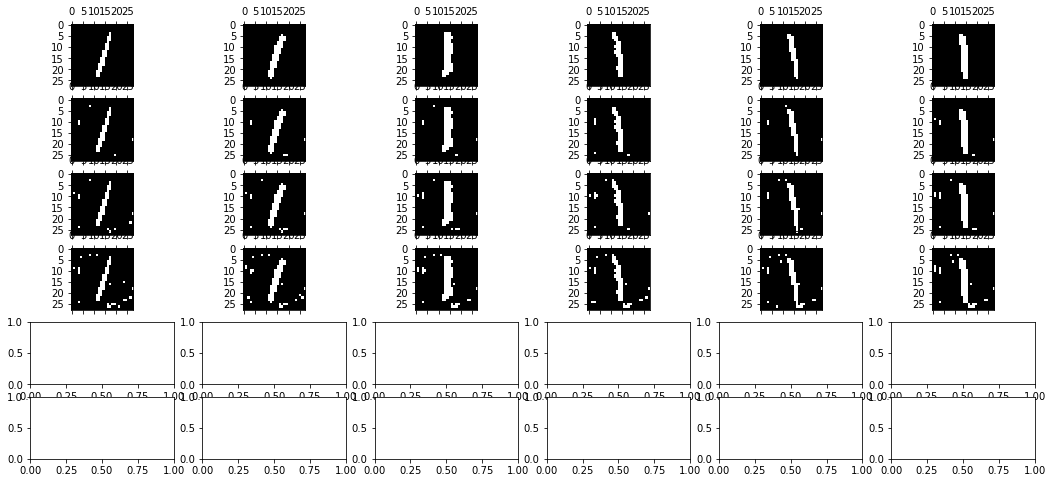

In [20]:
#display the clean examples and adversarial examples
n_examples = 6
fig, axs = plt.subplots(6, n_examples, figsize = (18, 8))

for i in range(n_examples):
    #clean
    axs[0][i].matshow(np.reshape(pre_attack_samples[i], (28, 28)), vmin = 0, vmax = 1., cmap = plt.cm.gray)
    #scale of perturbation is 5
    axs[1][i].matshow(np.reshape(modified_smps_opt_5[i], (28, 28)), vmin = 0, vmax = 1., cmap = plt.cm.gray)
    #scale of perturbation is 10
    axs[2][i].matshow(np.reshape(modified_smps_opt_10[i], (28, 28)), vmin = 0, vmax = 1., cmap = plt.cm.gray)
    #scale of perturbation is 20
    axs[3][i].matshow(np.reshape(modified_smps_opt_20[i], (28, 28)), vmin = 0, vmax = 1., cmap = plt.cm.gray)
plt.show()

the distortion data is saved to [./MNIST/opt_5.data]
the distortion data is saved to [./MNIST/opt_10.data]
the distortion data is saved to [./MNIST/opt_20.data]
====================the save data=================


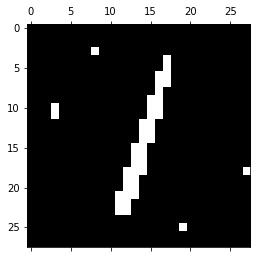

In [21]:
#save adversarial samples
save_path1 = os.path.join(save_dir, 'opt_5.data')
save_path2 = os.path.join(save_dir, 'opt_10.data')
save_path3 = os.path.join(save_dir, 'opt_20.data')
with open(save_path1, 'wb') as fsave:
    np.save(fsave, modified_smps_opt_5)
    print("the distortion data is saved to [%s]" % save_path1)
    
with open(save_path2, 'wb') as fsave:
    np.save(fsave, modified_smps_opt_10)
    print("the distortion data is saved to [%s]" % save_path2)
    
with open(save_path3, 'wb') as fsave:
    np.save(fsave, modified_smps_opt_10)
    print("the distortion data is saved to [%s]" % save_path3)

#check
with open(save_path1, 'rb') as fload:
    adv_samples = np.load(fload)
    print("====================the save data=================")
    plt.matshow(adv_samples[0, :].reshape(28, 28), vmin = 0., vmax = 1., cmap = plt.cm.gray)
    plt.show()